In [3]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

import numpy as np 
import pandas as pd 
import datetime
import csv

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import mylibs11 as l11



from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

rcParams['figure.figsize'] = 15,6
sns.set_palette('Set2')
%matplotlib inline

c:\users\pff\appdata\local\programs\python\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [52]:
data = pd.read_csv('BTC_DATA_fin.csv', index_col=0)
data.index = pd.to_datetime(data.index)

Predicting only Bitcoin price

In [53]:
data = data['BTC_Close']

In [54]:
ts = data

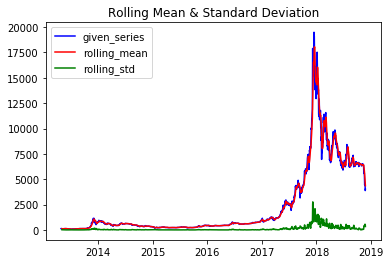

Results of Dickey-Fuller Test:
Test Statistic                   -2.030059
p-value                           0.273551
#Lags Used                       23.000000
Number of Observations Used    2013.000000
Critical Value (10%)             -2.567535
Critical Value (5%)              -2.862977
Critical Value (1%)              -3.433603
dtype: float64


In [55]:
from statsmodels.tsa.stattools import adfuller
def test_for_stationary(input_data):
    r_mean = input_data.rolling(window = 7,center=False).mean()
    r_std = input_data.rolling(window = 7,center=False).std()
    
    # plotting the data
    given = plt.plot(input_data, color = 'blue', label = 'given_series')
    rolling_mean = plt.plot(r_mean, color = 'red', label = 'rolling_mean')
    rolling_std = plt.plot(r_std, color ='green', label = 'rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
      
test_for_stationary(ts)   

The test statistic is very large compared to the crtical value. The above series show that rolling mean value varies with time and is not stationary. The series needs to be Stationarized. we need to eliminate the trend and seasonality from the series to make it stationary

### ELIMINATING TREND by logtransforming

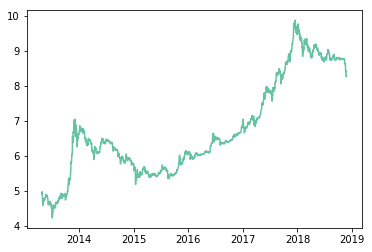

In [56]:
ts_logtransformed = np.log(ts)
plt.plot(ts_logtransformed)

### Smoothing by Rolling average

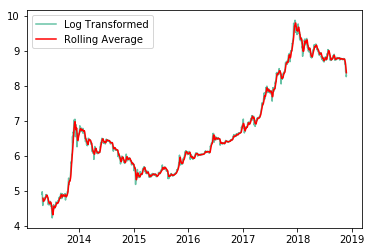

In [57]:
Rolling_average = ts_logtransformed.rolling(window = 7, center= False).mean()
plt.plot(ts_logtransformed, label = 'Log Transformed')
plt.plot(Rolling_average, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')

Subtract this Rolling average this from the original log transfomred series.

In [58]:
log_Rolling_difference = ts_logtransformed - Rolling_average

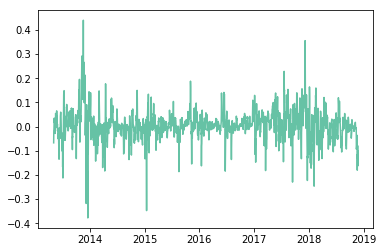

In [59]:
log_Rolling_difference.dropna(inplace=True)
plt.plot(log_Rolling_difference)

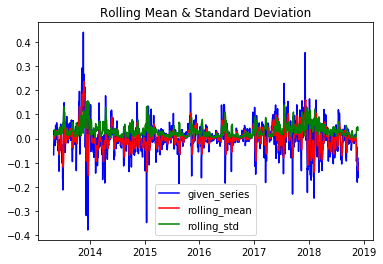

Results of Dickey-Fuller Test:
Test Statistic                -7.990237e+00
p-value                        2.485748e-12
#Lags Used                     2.200000e+01
Number of Observations Used    2.008000e+03
Critical Value (10%)          -2.567537e+00
Critical Value (5%)           -2.862980e+00
Critical Value (1%)           -3.433611e+00
dtype: float64


In [60]:
test_for_stationary(log_Rolling_difference)

Use exponential_weighted_moving_average instead of moving average to improve the solution

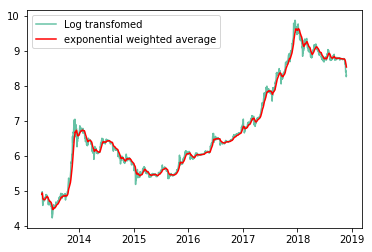

In [61]:
expwighted_avg = ts_logtransformed.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_logtransformed, label = 'Log transfomed')
plt.plot(expwighted_avg, color='red', label = 'exponential weighted average')
plt.legend(loc = 'best')

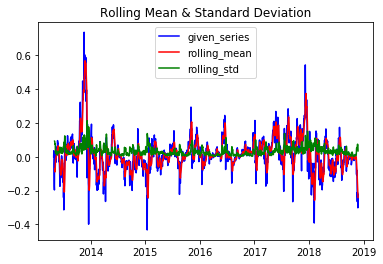

Results of Dickey-Fuller Test:
Test Statistic                -6.380734e+00
p-value                        2.225690e-08
#Lags Used                     2.300000e+01
Number of Observations Used    2.013000e+03
Critical Value (10%)          -2.567535e+00
Critical Value (5%)           -2.862977e+00
Critical Value (1%)           -3.433603e+00
dtype: float64


In [62]:
log_expmovwt_diff = ts_logtransformed - expwighted_avg

test_for_stationary(log_expmovwt_diff)

Now the current time series is stationary,the TS (test_statistic) value is less than 1% critcal value. Since weights are assigned to values from the starting index. Therefore the test works

### Seasonality Adjustment by Differencing

Date
2013-04-28         NaN
2013-04-29         NaN
2013-04-30         NaN
2013-05-01         NaN
2013-05-02         NaN
2013-05-03         NaN
2013-05-04         NaN
2013-05-05   -0.146592
2013-05-06   -0.252382
2013-05-07   -0.220449
Name: BTC_Close, dtype: float64

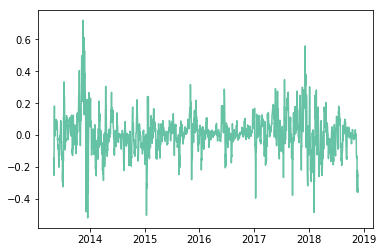

In [63]:
ts_diff_logtrans = ts_logtransformed -ts_logtransformed.shift(7)
plt.plot(ts_diff_logtrans)
ts_diff_logtrans.head(10)

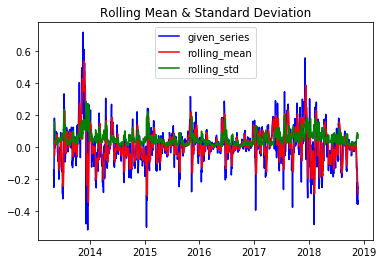

Results of Dickey-Fuller Test:
Test Statistic                -7.232892e+00
p-value                        1.973467e-10
#Lags Used                     2.200000e+01
Number of Observations Used    2.007000e+03
Critical Value (10%)          -2.567537e+00
Critical Value (5%)           -2.862981e+00
Critical Value (1%)           -3.433612e+00
dtype: float64


In [64]:
ts_diff_logtrans.dropna(inplace=True)
test_for_stationary(ts_diff_logtrans)

## ARIMA MODEL

In [65]:
from statsmodels.tsa.arima_model import ARIMA

In [66]:
ts_diff_logtrans = ts_diff_logtrans.fillna(0)

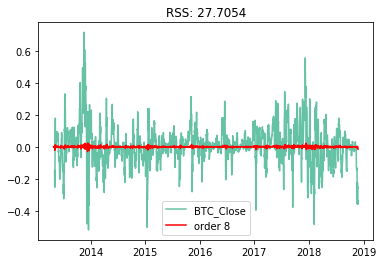

In [67]:
model = ARIMA(ts_logtransformed, order=(8, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_AR.fittedvalues, color='red', label = 'order 8')
RSS = results_AR.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc = 'best')

## MA MODEL

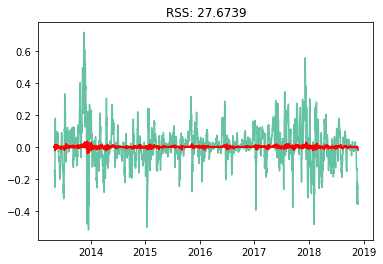

In [68]:
model = ARIMA(ts_logtransformed, order=(0, 1,18)) 
results_MA = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_MA.fittedvalues, color='red')
RSS = results_MA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))

In [69]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)

In [70]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [71]:
predictions_ARIMA_log = pd.Series(ts_logtransformed.iloc[0], index=ts_logtransformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)


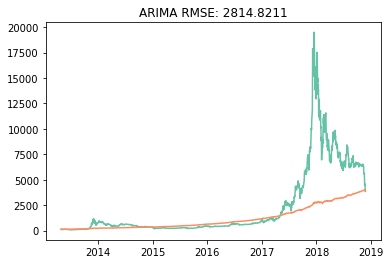

In [72]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('ARIMA RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

In [73]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

In [74]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

In [75]:
predictions_MA_log = pd.Series(ts_logtransformed.iloc[0], index=ts_logtransformed.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)

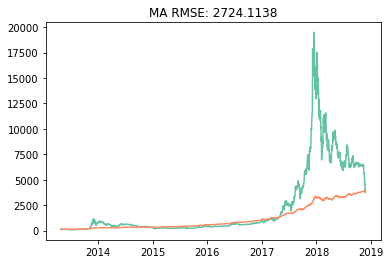

In [76]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(data)
plt.plot(predictions_MA)
plt.title('MA RMSE: %.4f'% np.sqrt(sum((predictions_MA-data)**2)/len(data)))